# <center>Digital Image Processing - Problem Set 3</center>

### Student Names: Jorge Aguilar, Jorge Díaz, Jorge Lambraño

### Instructions

This Problem Set covers the topics of frequency domain filtering and color image processing.<br>

Your solutions to the following problems should include commented source code and a short description of each function. You should test your functions with several input images, besides the ones provided here. Include the input and output images that you used for experimentation. Analyze your results. If you discover something interesting, let us know!

### Problem 1

Visualize the Fourier spectrum of an image. Write a function that visualizes the spectrum of an input gray-scale image. The function should perform the following steps:

1. Compute the FFT of the input image using the FFT function <tt>numpy.fft.fft2</tt>.
2. Shift the transform to center the origin in the middle of the image using <tt>numpy.fft.fftshift</tt>.
3. The Fourier transform contains complex numbers, so we usually analyze its phase and spectrum components. Write commands that compute the Fourier spectrum from the shifted Fourier transform.
4. The resulting spectrum is difficult to visualize if plotted directly. Instead, we usually apply a logarithmic intensity transform to the spectrum before visualizing. Use the <tt>numpy.log</tt> function to accomplish this.
5. Plot the modified spectrum.

Test your function by applying it to the images <tt>face.png</tt>, <tt>blown_ic.png</tt>, <tt>test_pattern_blurring_orig.png</tt>, <tt>translated_rectangle.png</tt> and <tt>rectangle.png</tt>.

Please comment your results.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
%matplotlib inline

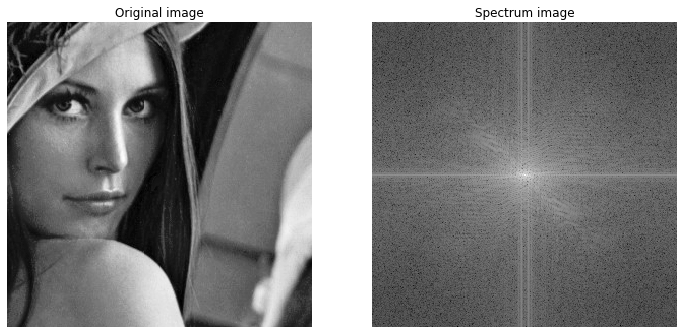

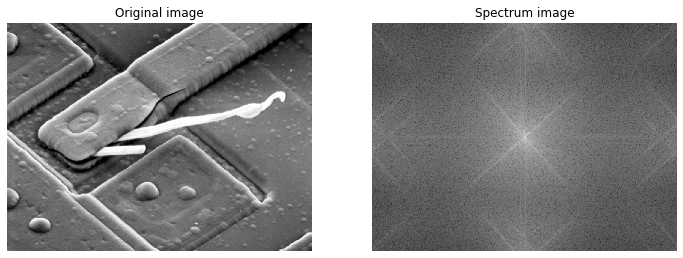

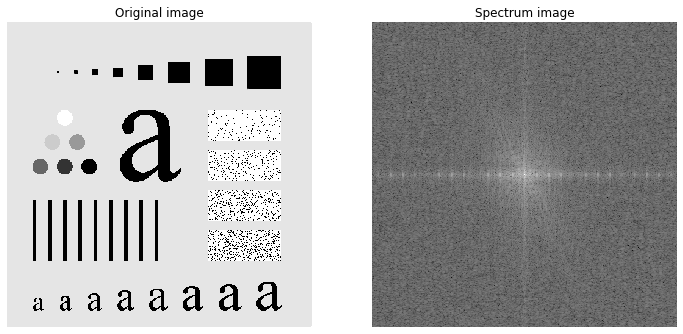

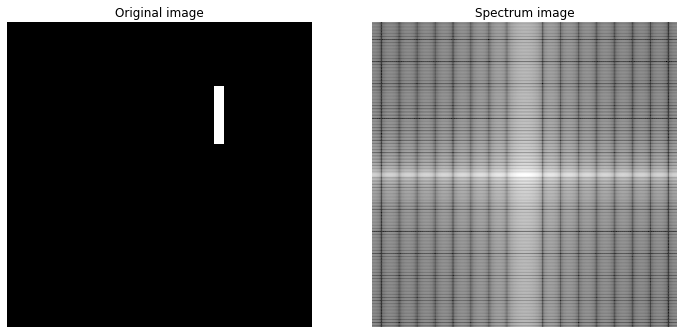

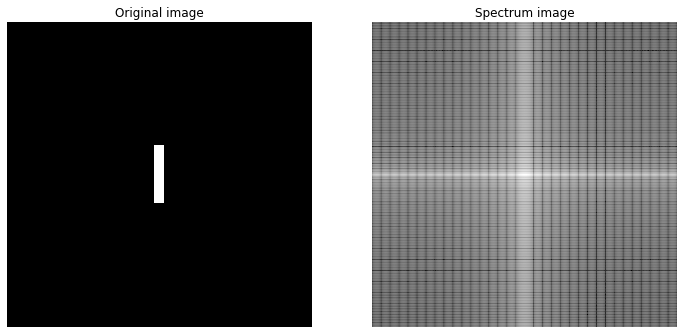

In [2]:
# problem_1.py
#-------------------------------------------------------------------------------
def plot_image(image, title):
    plt.imshow(image, cmap = 'gray')
    plt.title(title)
    plt.axis('off')
#-------------------------------------------------------------------------------
def gamma_image(imagen, gamma):
    imagen_out = 1 * np.power(imagen/255.0, 0.2)
    return (imagen_out*255).astype('int')
#-------------------------------------------------------------------------------
def log_image(image):
    return 20 * np.log(np.abs(image + 1))
#-------------------------------------------------------------------------------
def fourier_image(image):
    fft_image = np.fft.fft2(image)
    shift_fft = np.fft.fftshift(fft_image)
    return shift_fft
#-------------------------------------------------------------------------------
def process_1(filename):
    # define a figure
    fig = plt.figure(figsize = (12,12))
    # load image
    image = cv2.imread('files/' + filename, cv2.cv2.IMREAD_GRAYSCALE)
    # display original image 
    plt.subplot(1, 2, 1)
    plot_image(image, 'Original image')
    # compute fourier image
    fft_image = fourier_image(image)
    # use a logaritmic transformation
    log_correction = log_image(fft_image)
    # display gamma image 
    plt.subplot(1, 2, 2)
    plot_image(log_correction, 'Spectrum image')
    # display title on figure
    #plt.suptitle('Image: ' + filename, fontsize = 16)   
#-------------------------------------------------------------------------------
def main1():
    image_names = ['face.png', 'blown_ic.png', 'test_pattern_blurring_orig.png', 
                   'translated_rectangle.png', 'rectangle.png']
    for filename in image_names:
        process_1(filename)
    plt.show()
#-------------------------------------------------------------------------------
main1()

### Problem 2

Frequency domain filtering. Write a PYTHON function that performs high-frequency emphasis (hfe) filtering. Recall that an hfe filter is defined as:
\begin{equation}
H_{hfe}(u,v) = a + b \cdot H_{hp}(u,v)
\end{equation}
where $a$ is the offset, $b$ is the high-frequency amplification and $H_{hp}$ is the transfer function of a high-pass filter. Your function should be based on a second-order high-pass Butterworth filter with a cut-off frequency $D_0$, which is given by:
\begin{equation}
H_{hp}(u,v) = \frac{1}{1 + \left[\frac{D_0}{D(u,v)}\right]^{2n}}.
\end{equation}
<b>Note. </b> $D(u,v)$ measures the Euclidean distance from the point $(u,v)$ to the center of the frequency plane.

Use your function and filters on the image <tt>chest.jpg</tt> to reproduce the image enhancement illustrated below.

<img src="files/chest.jpg" width=200> <img src="files/out.png" width=200>

The outline of the process is the following:

1. Create a high-pass Butterworth filter with a frequency domain dimension of 2 times the size of the input image. Plot the filter image.
2. Compute the FFT of the input image using the function <tt>numpy.fft.fft2</tt>. The FFT should have frequency domain dimensions equal to the dimensions of the filter, which should be set using the input parameters of the <tt>fft2</tt> function. Plot the FFT image.
3. Filter the image using the high-pass Butterworth filter. To filter an image in the frequency domain, you should multiply the fourier transform of the image and the frequency response of the filter. To go back to the spatial domain, you need to apply the inverse FFT and take the real component of the resut. Plot the resulting image.
4. Create a high-frequency emphasis filter based on the Butterworth filter of step 1. Plot the filter image.
5. Filter the image using a high-frequency emphasis filter. Plot the resulting image.
6. After filtering, you may need to stretch the intensity values of each resulting image to the range [0, 255]. You can achieve this by substracting the minimum intensity value, dividing by the maximum and multiplying the result by 255.
7. Apply histogram equalization to the image obtained in the previous step. You should obtain a similar result to that shown above.

Use the following parameters for the filters: $a = 0.5$, $b = 2$, $n=2$ and $D_0$ should be set to $5\%$ of the vertical dimension of the filter.

Please comment your results.

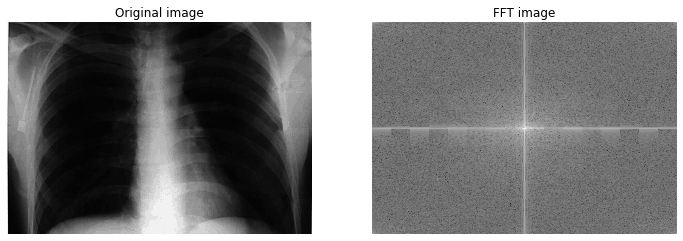

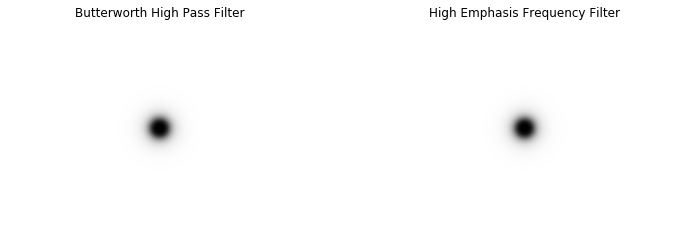

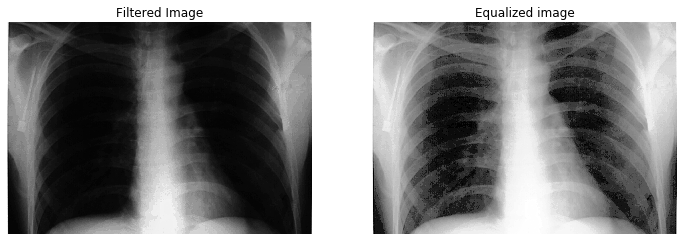

In [24]:
# problem_2.py
#-------------------------------------------------------------------------------
def dist(x1, y1, x2, y2):
    return np.power(np.power(x1 - x2, 2) + np.power(y1 - y2, 2),0.5)
#-------------------------------------------------------------------------------
def log_image(image):
    return 20 * np.log(np.abs(image + 1))
#-------------------------------------------------------------------------------
def fourier_image(image):
    (height, width) = image.shape
    fft_image = np.fft.fft2(image, [height*2,width*2])
    #shift_fft = np.fft.fftshift(fft_image)
    return fft_image
#-------------------------------------------------------------------------------
def butter_low_pass(image, n, percent, D0in=0.05):
    # get dimentions from image
    (height, width) = image.shape
    # cut 
    D0 = (D0in * 2.0 * height) ** (2 * n)  #D0 = 2.0 * 0.05 * height
    hhp = np.zeros((2 * height, 2 * width), dtype = np.float)
    x = np.arange(-1 * width, width, dtype=np.float32)
    y = np.arange(-1 * height, height, dtype=np.float32)
    xv, yv = np.meshgrid(y, x, sparse=True, indexing='ij')
    distance = np.square(xv) + np.square(yv)
    distance[height, width] = np.finfo(distance.dtype).eps # avoid division by zero
    hhp =  1 / (1 + D0 / (np.power(distance, n)))
    return hhp 
#-------------------------------------------------------------------------------
def butter_high_pass(hhp, a, b):
    hfe = a + b * hhp
    return hfe
#-------------------------------------------------------------------------------
def plot_image(image, title):
    plt.imshow(image, cmap = 'gray')
    plt.title(title)
    plt.axis('off')
#-------------------------------------------------------------------------------
def stretch_intensity(image):
    (h,w) = np.shape(image)
    matrix_image = image[:int(h/2),:int(w/2)]
    #new_image = matrix_image/255 
    min_value = np.min(matrix_image)
    max_value = np.max(matrix_image)
    new_image = abs((matrix_image - min_value)*255/max_value)
    #print(new_image)
    return new_image
#-------------------------------------------------------------------------------
def process_2(image):
    # Create a high-pass Butterworth filter with a frequency domain 
    # dimension of 2 times the size of the input image.
    hhp = butter_low_pass(image, 2, 0.05)
    # Create a high-frequency emphasis filter based on the 
    # Butterworth low pass filter
    hfe = butter_high_pass(hhp, 0.5, 2)
    # Get fft from original image
    fft_image = fourier_image(image)
    shift_fft = np.fft.fftshift(fft_image)
    # Multiply hfe filter and fft image 
    filtered_fft = np.fft.ifft2(np.multiply(hfe,fft_image))
    # resize and strech image_values
    stretch_image = stretch_intensity(filtered_fft)
    # Equalized histogram image
    equalized_img = cv2.equalizeHist(np.array(stretch_image,dtype=np.uint8))
    # Display original image 
    plt.figure(figsize = (12,12))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap = 'gray')
    plt.title('Original image')
    plt.axis('off')
    # Display FFT image
    plt.subplot(1,2,2)
    #use a logaritmoc transformation to see better the fourier image
    plt.imshow(log_image(shift_fft), cmap = 'gray')
    plt.title('FFT image')
    plt.axis('off')
    # display filter 
    plt.figure(figsize = (12,12))
    plt.subplot(1,2,1)
    plt.imshow(hhp, cmap = 'gray')
    plt.title('Butterworth High Pass Filter')
    plt.axis('off')
    #
    plt.subplot(1,2,2)
    plt.imshow(hfe, cmap = 'gray')
    plt.title('High Emphasis Frequency Filter')
    plt.axis('off')
    # Filtered image 
    plt.figure(figsize = (12,12))
    plt.subplot(1,2,1)
    plt.imshow(stretch_image, cmap = 'gray')
    plt.title('Filtered Image')
    plt.axis('off')
    # Equalized-Filtered image 
    plt.subplot(1,2,2)
    plt.imshow(equalized_img, cmap = 'gray')
    plt.title('Equalized image')
    plt.axis('off')    
    # show all 
    plt.show() 
    
#------------------------------------------------------------------------------
def main2():
    # define 
    # load image 
    filename = 'chest.jpg'
    image = cv2.imread('files/' + filename, cv2.IMREAD_GRAYSCALE)
    process_2(image)
#------------------------------------------------------------------------------
main2()

### Problem 3

Color spaces. Write a function that converts an image from the RGB color
space to HSI color space. Write another function that converts an image from the HSI
color space to RGB color space. You should use the homework equations to implement these conversions.

When plotting images in the HSI space, you should plot each channel separately, using one image for the H channel, another for the S channel and another for the I channel.

Test your function converting images from RGB to HSI and back to RGB.

In [ ]:
def angle(R, G, B):
    if (R == G and G == B):
        ang = 0
    else: 
        num = 0.5*(2 * R - G - B)
        den = np.sqrt(np.power((R - G),2) + (R - B)*(G - B))
        nd = num/den
        if (nd > 1):
            ang = 0
        elif (nd < -1):
            ang = 180
        else: 
            ang = np.degrees(np.arccos(nd))
    return ang
#-------------------------------------------------------------------------------
def rgb2hsi(pixelRGB):
    # Normalize pixels values 
    [R, G, B] = np.array(pixelRGB/255.0)
    # Get H value
    H = angle(R,G,B)
    if(B > G):
        H = 360 - H 
    # Get S value 
    pixel_sum = np.sum([R, G, B])
    S = 1 - 3 * np.min([R, G, B])/pixel_sum
    # get I value
    I = pixel_sum/3
    return np.array([H, S, I])
#-------------------------------------------------------------------------------
def imageRGB2HSI(image):
    h, w = image.shape[:2]
    # out_image = np.zeros(image.shape)
    [R, G, B] = image/255.0
    HueMat = 
    
    for i in range(h):
        for j in range(w):
            out_image[i][j] = rgb2hsi(image[i][j])
    return out_image
#-------------------------------------------------------------------------------
def imageHSI2RGB(image):
    h, w = image.shape[:2]
    out_image = np.zeros(image.shape)
    for i in range(h):
        for j in range(w):
            out_image[i][j]  = hsi2rgb(image[i][j])
    return out_image
#-------------------------------------------------------------------------------
def hsi2rgb(pixelHSI):
    [H, S, I] = pixelHSI
    if (H >= 0 and H < 120):
        B = I*(1 - S)
        R = I * (1 + S * np.cos(np.radians(H))/np.cos(np.radians(60 - H)))
        G = 3*I - (R + B)
    elif (H >= 120 and H < 240):
        H = H - 120
        R = I * (1 - S)
        G = I * (1 + S * np.cos(np.radians(H))/np.cos(np.radians(60 - H)))
        B = 3*I - (R + G)
    else:
        H = H - 240
        G = I * (1 - S)
        B = I * (1 + S * np.cos(np.radians(H))/np.cos(np.radians(60 - H)))
        R = 3 * I - (G + B)
    pixelRGB = np.array([R, G, B])
    return pixelRGB
#-------------------------------------------------------------------------------    
def main():
    # image are normalized RBG values [0 - 1]
    v = cv2.imread('files/rgb_image.jpg',cv2.IMREAD_COLOR)
    hsi = imageRGB2HSI(v)
    original = imageHSI2RGB(hsi)
    plt.figure()
    plt.imshow(v)
    plt.title('Original image')
    plt.axis('off')
    plt.figure()
    plt.imshow(hsi)
    plt.title('HSI image')
    plt.axis('off')
    plt.figure()
    plt.imshow(original)
    plt.title('Restored image')
    plt.axis('off')
    plt.show()
#-------------------------------------------------------------------------------
main()
    

### Problem 4

Manipulating color images. Write a function that converts a color image from the RGB to
the HSI color space, modifies the ‘I’ channel by applying histogram equalization, and revert
back the image to the RGB color space. Apply this function to enhance the image <tt>dark_fountain.jpg</tt>.

### Problem 5 

Manipulating color images. Consider the RGB color image <tt>squares.jpg</tt>, where the
squares are pure red, green and blue.

<img src="files/squares.jpg" width=200 />

1. Convert this image to the HSI color space. Blur the H component of the image using a 25x25 averaging mask, and convert it back to RGB. How do you explain the obtained result?
2. Repeat, blurring only the saturation component this time. How do you explain the result?


## Problem 6

False color. Write a Python function that produces a false color visualization of
the input gray-scale image as follows:

1. If the intensity of an input pixel is lower than a threshold $T$, then the color of the corresponding pixel should be blue.
2. If the intensity of an input pixel is larger or equal than a threshold $T$, then the color of the corresponding pixel should be yellow.

Use your function to reproduce the following result on the image <tt>weld_x-ray.jpg</tt>:

<img src="files/weld_x-ray.jpg" width=200 /> <img src="files/Fig6.21(b).jpg" width=200 /> 

In [ ]:
#-------------------------------------------------------------------------------
def false_color(image,T):
    (height, width) = image.shape
    out=np.zeros((height, width, 3), np.uint8)
    blues = np.where(image < T, 255, 0)
    yellows = 255 - blues
    out[:,:,0] = blues; out[:,:,1] = yellows; out[:,:,2] = yellows;
    return out
#-------------------------------------------------------------------------------
def main6(): 
    img = cv2.imread("files/weld_x-ray.jpg", cv2.IMREAD_GRAYSCALE)
    img_out = false_color(img,250)
    plt.figure(figsize = (12, 12))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('False-color image')
#-------------------------------------------------------------------------------
main6()

## Problem 7

Green screen effects. Write a function that replaces the green background of the image <tt>hiro.jpg</tt> with a background image of your choice.

<img src="files/hiro.jpg" width=300>

In [ ]:
#-------------------------------------------------------------------------------
def plot_image(image, title):
    plt.imshow(image, cv2.COLOR_HSV2RGB)
    plt.title(title)
    plt.axis('off')
#-------------------------------------------------------------------------------
def main7(): 
    # load hiro and datecenter image 
    img = cv2.imread('files/hiro.jpg',cv2.IMREAD_COLOR)
    img_bkg = cv2.imread('files/datacenter.jpg',cv2.IMREAD_COLOR)
    # take dimentions from Hiro's image
    heigh, width = img.shape[:2] 
    # resize dimentions to datacenter image 
    img_bkg = cv2.resize(img_bkg,(width, heigh), interpolation = cv2.INTER_CUBIC)
    # Converts an image from one color space to HSV format.
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_bkg_hsv = cv2.cvtColor(img_bkg, cv2.COLOR_BGR2HSV)
    # define range of green color in HSV
    lower_green = np.array([50, 10, 50]) 
    upper_green = np.array([60, 255, 255]) 
    # Threshold the HSV image to get only green colors 
    green_mask = cv2.inRange(img_hsv, lower_green, upper_green) #
    # Threshold the HSV image to get only green colors
    img_fg = cv2.bitwise_and(img_hsv, img_hsv, mask= 255 - green_mask)
    # Threshold the HSV image to get only colors differents to green 
    img_bg = cv2.bitwise_and(img_bkg_hsv, img_bkg_hsv, mask = green_mask)
    # Add the images 
    img_out = cv2.add(img_fg, img_bg)
    # Show orignal image
    plt.figure(figsize=(10, 10))
    plt.subplot(2,1,1)
    plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)); 
    plt.axis('off');
    plt.title('Original Image')
    # display background image
    plt.subplot(2,1,2)
    plt.imshow(cv2.cvtColor(img_bkg, cv2.COLOR_BGR2RGB)); 
    plt.axis('off');
    plt.title('Background Image')
    # Show mask
    plt.figure(figsize=(10, 10))
    plt.subplot(2,1,1)
    plt.imshow(green_mask, cmap = 'gray');
    plt.title('Mask Frame')
    # Display final result
    plt.subplot(2,1,2)
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_HSV2RGB)); 
    plt.axis('off')
    plt.title('Final Result')
    plt.show()
#-------------------------------------------------------------------------------    
main7() 